<font color='blue'>
<br><h1>CONTENT:</h1>

 * [IMPORT LIBRARY](#1)
 * [DATASET PREPRATION](#2)
 * [MODELING](#3)
 * [Apply ResNet101](#4)
 * [APPLY VGG19](#5)
 * [Xception](#6)
 * [MobileNet](#7)
 * [CONCLUSION](#8)

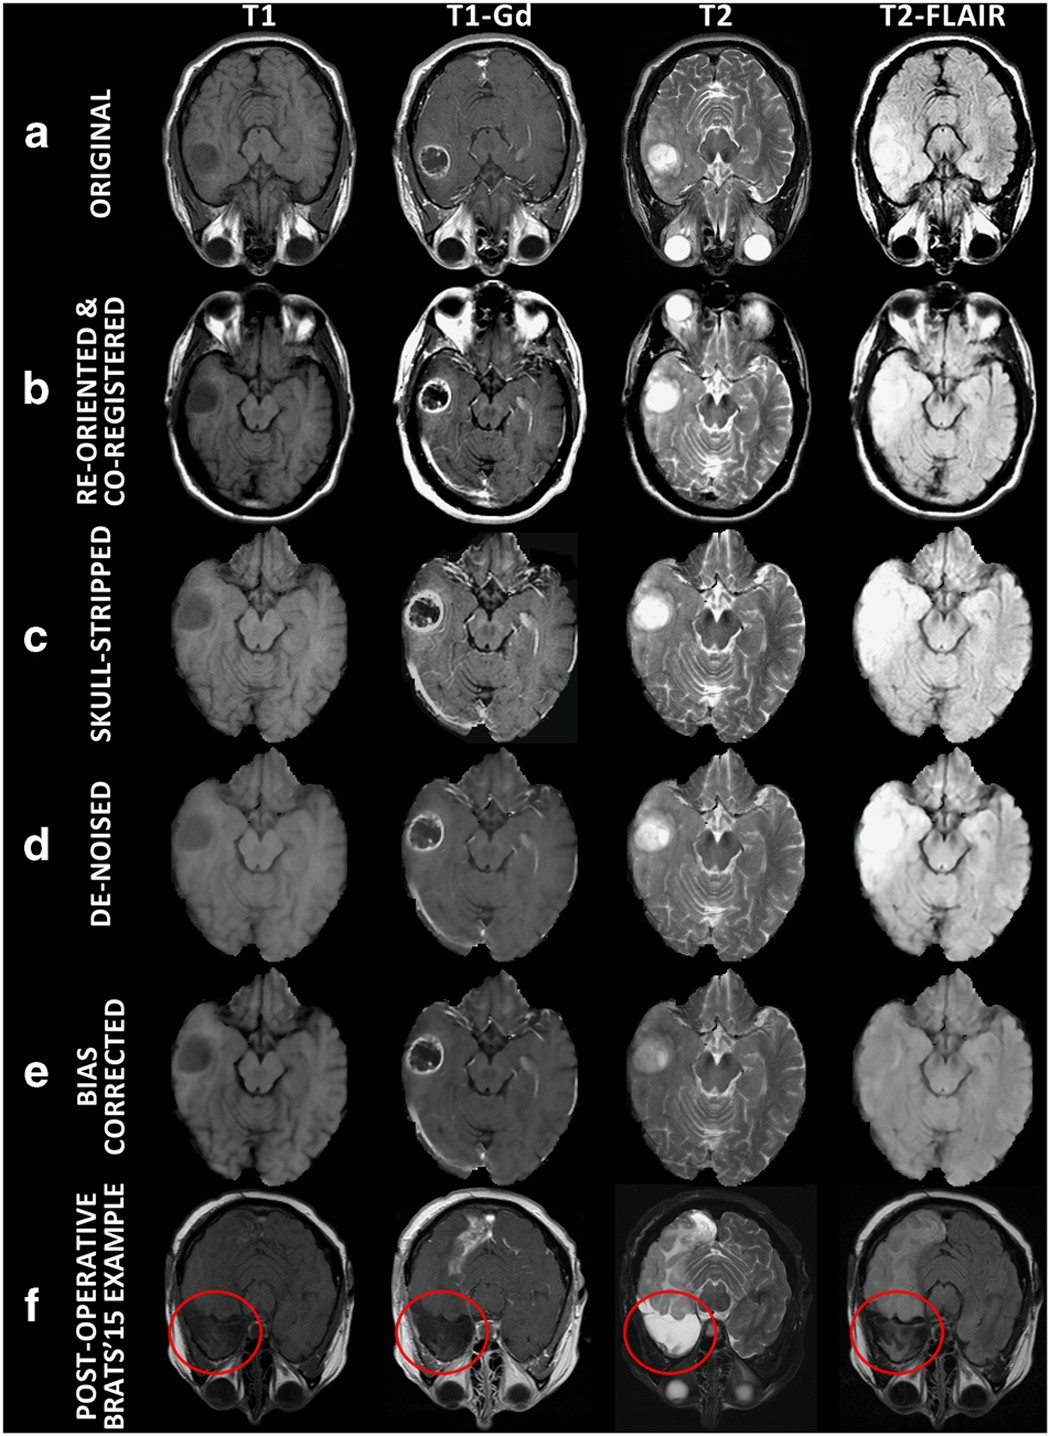

<a id="1"></a>
# IMPORT LIBRARY
The provided Python code utilizes TensorFlow and Keras for image classification. It defines a convolutional neural network (CNN) model with layers for convolution, pooling, flattening, and dense connections. The model is compiled using categorical crossentropy loss and Adam optimizer. ImageDataGenerator is employed for data augmentation. The code also incorporates callbacks, including ModelCheckpoint for saving the best model during training. This script is designed for image classification tasks, with a focus on convolutional neural network architecture and data augmentation techniques.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalMaxPooling2D,Flatten, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import os
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
train_datasets = "/kaggle/input/brain-tumor-classification-mri/Training"
validation_datasets = "/kaggle/input/brain-tumor-classification-mri/Testing"

In [3]:
batch_size = 64
image_size = 224
epochs = 3

<a id='2'></a>
# DATASET PREPRATION

**Augmentation** is a data preprocessing technique in machine learning, particularly in image processing, involving random transformations like rotation, flipping, and zooming to enhance dataset diversity and improve model generalization.
   
This Python function, named `prepare_the_datasets`, sets up data generators using TensorFlow's ImageDataGenerator for training and validation datasets. It applies rescaling, shearing, zooming, and horizontal flipping for augmentation. The function then generates batches of augmented images and corresponding labels from the specified directories. The images are resized to a given size, and categorical class mode is used. The resulting generators are crucial for efficiently feeding image data into a deep learning model during training. This function streamlines the preprocessing steps, enhancing the training process for convolutional neural networks in image classification tasks.

In [4]:

def prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size):

    train_datasets_generator = ImageDataGenerator(rescale=1./255,
                                                  shear_range = 0.2,
                                                  zoom_range = 0.2,
                                                  horizontal_flip = True,
                                                  fill_mode = "nearest")


    validation_datasets_generator = ImageDataGenerator(rescale=1.0/255)


    train_datasets_generator_data = train_datasets_generator.flow_from_directory(
        batch_size = batch_size,
        directory = train_datasets,
        shuffle = True,
        target_size = (image_size, image_size),
        class_mode = "categorical"
    )

    validation_datasets_generator_data = validation_datasets_generator.flow_from_directory(
        batch_size = batch_size,
        directory = validation_datasets,
        shuffle = True,
        target_size = (image_size, image_size),
        class_mode = "categorical"
    )


    return train_datasets_generator_data, validation_datasets_generator_data

In [5]:
train_data , validation_data = prepare_the_datasets(train_datasets, validation_datasets, batch_size, image_size)

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


<a id='3'></a>
# MODELING
This code defines a Sequential model using TensorFlow and Keras for image classification. The model consists of three convolutional layers with max-pooling, followed by flattening and two dense layers. The output layer has softmax activation for multiclass classification. The model is compiled with the Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric. This architecture is suitable for tasks where convolutional neural networks are effective, such as image classification with multiple classes.

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (image_size, image_size, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D(2, 2),

    Flatten(),

    Dense(512, activation = "relu"),
    Dense(4, activation = "softmax")
])

In [7]:
model.compile(optimizer="adam",
              loss = "categorical_crossentropy",
              metrics = ["accuracy"]
              )

In [8]:
model_checkpoint_filpath = "model_checkpoint.h5"
callbacks_checkpoints = ModelCheckpoint(

    filepath = model_checkpoint_filpath,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [9]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = epochs,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints]
                    )

Epoch 1/3
45/45 [==============================] - 57s 1s/step - loss: 2.0310 - accuracy: 0.4254 - val_loss: 4.0129 - val_accuracy: 0.3198
Epoch 2/3
45/45 [==============================] - 37s 811ms/step - loss: 2.8473 - accuracy: 0.5233 - val_loss: 8.8991 - val_accuracy: 0.3883
Epoch 3/3
45/45 [==============================] - 36s 802ms/step - loss: 4.0923 - accuracy: 0.6084 - val_loss: 9.4839 - val_accuracy: 0.3350


In [10]:
loss, accuracy = model.evaluate(validation_data, batch_size=batch_size)

7/7 [==============================] - 1s 176ms/step - loss: 10.8990 - accuracy: 0.3274


<a id='4'></a>
# Apply ResNet101

This code utilizes a pre-trained ResNet101 model for transfer learning in image classification. The pre-trained model's layers are frozen to retain learned features, and a custom model is built by adding a global max-pooling layer and dense layers. The model is compiled with the Adam optimizer and categorical crossentropy loss. A ModelCheckpoint callback is implemented to save the best model based on validation accuracy. The training process is executed using the fit method, with specified training and validation data, and the checkpoint callback. Finally, the model is evaluated on the validation data, and both loss and accuracy metrics are computed. This script streamlines transfer learning for image classification tasks, leveraging the powerful ResNet101 architecture.

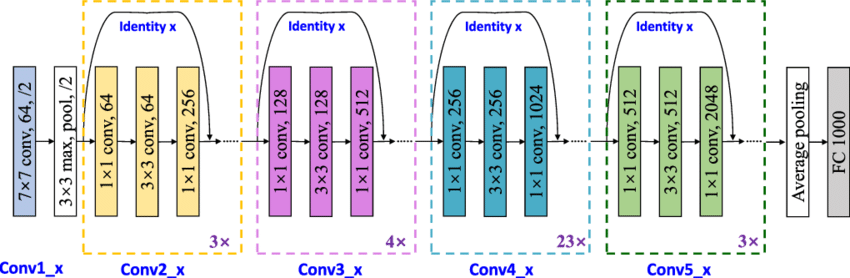

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense



# Load pre-trained ResNet101 model without the top (fully connected) layers
base_model = tf.keras.applications.ResNet101(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

# Freeze the layers of the pre-trained ResNet101 model
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of the pre-trained ResNet101
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())  # Use GlobalMaxPooling2D instead of MaxPooling2D
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Use 'binary' if it is two classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


171446536/171446536 [==============================] - 6s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 7, 7, 2048)        42658176  
                                                                 
 global_max_pooling2d (Glob  (None, 2048)              0         
 alMaxPooling2D)                                                 
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 43709316 (166.74 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 42658176 (162.73 MB)
_________________________________________________________________


In [12]:
model_checkpoint_filpath3 = "model_checkpoint.h5"
callbacks_checkpoints3 = ModelCheckpoint(

    filepath = model_checkpoint_filpath3,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [13]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = epochs,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints3]
                    )

Epoch 1/3
45/45 [==============================] - 47s 875ms/step - loss: 2.1341 - accuracy: 0.3836 - val_loss: 2.4438 - val_accuracy: 0.2766
Epoch 2/3
45/45 [==============================] - 38s 847ms/step - loss: 1.0940 - accuracy: 0.5230 - val_loss: 2.4823 - val_accuracy: 0.3147
Epoch 3/3
45/45 [==============================] - 39s 860ms/step - loss: 0.9593 - accuracy: 0.5983 - val_loss: 2.3534 - val_accuracy: 0.3553


In [14]:
loss, accuracy = model.evaluate(validation_data, batch_size=batch_size)

7/7 [==============================] - 2s 187ms/step - loss: 2.3534 - accuracy: 0.3553


<a id='5'></a>
# Apply VGG19

This code implements transfer learning using the VGG19 architecture for image classification. It loads the pre-trained VGG19 model without its top (fully connected) layers and freezes these layers. A custom model is then constructed by adding a global max-pooling layer and dense layers for classification. The model is compiled with the Adam optimizer and categorical crossentropy loss. A ModelCheckpoint callback is implemented to save the best model based on validation accuracy. The script concludes by evaluating the model on the validation data, computing and displaying both loss and accuracy metrics. Overall, this code facilitates efficient transfer learning with VGG19 for image classification tasks.

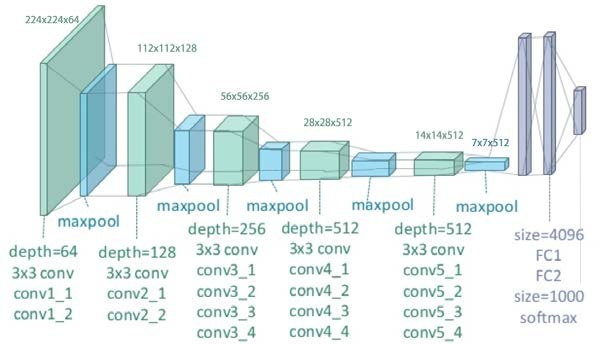

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense



# Load pre-trained VGG19 model without the top (fully connected) layers
base_model = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

# Freeze the layers of the pre-trained VGG19 model
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of the pre-trained VGG19
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())  # Use GlobalMaxPooling2D instead of MaxPooling2D
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Use 'binary' if it is two classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

80134624/80134624 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 20289092 (77.40 MB)
Trainable params: 264708 (1.01 MB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


In [16]:
model_checkpoint_filpath4 = "model_checkpoint.h5"
callbacks_checkpoints4 = ModelCheckpoint(

    filepath = model_checkpoint_filpath4,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [17]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = epochs,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints4]
                    )

Epoch 1/3
45/45 [==============================] - 43s 843ms/step - loss: 1.1453 - accuracy: 0.5376 - val_loss: 269.4795 - val_accuracy: 0.4746
Epoch 2/3
45/45 [==============================] - 37s 818ms/step - loss: 0.6853 - accuracy: 0.7265 - val_loss: 354.8209 - val_accuracy: 0.4898
Epoch 3/3
45/45 [==============================] - 37s 831ms/step - loss: 0.5665 - accuracy: 0.7787 - val_loss: 291.6678 - val_accuracy: 0.5279


In [18]:
loss, accuracy = model.evaluate(validation_data, batch_size=batch_size)

7/7 [==============================] - 1s 187ms/step - loss: 296.7933 - accuracy: 0.5381


<a id='6'></a>
# Apply Xception
This code employs transfer learning with the Xception architecture for image classification. It loads the pre-trained Xception model without its top layers and freezes these layers. A custom model is then created by adding a global max-pooling layer and dense layers for classification. The model is compiled using the Adam optimizer and categorical crossentropy loss. A ModelCheckpoint callback is used to save the best model based on validation accuracy. The training process is executed using the fit method, with specified training and validation data, and the checkpoint callback. The script concludes by evaluating the model on the validation data, computing and displaying both loss and accuracy metrics. This facilitates efficient transfer learning with Xception for image classification tasks.

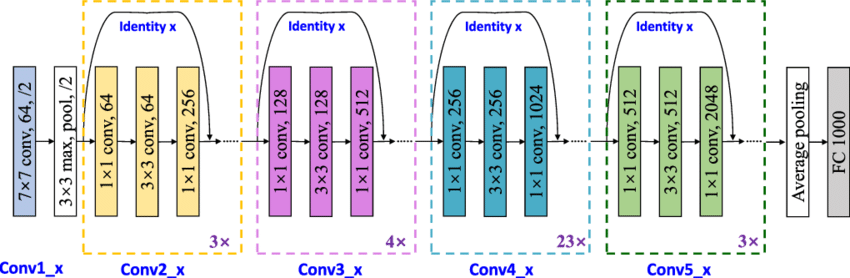

In [19]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense



# Load pre-trained Xception model without the top (fully connected) layers
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None)

# Freeze the layers of the pre-trained Xception model
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of the pre-trained Xception
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())  # Use GlobalMaxPooling2D instead of MaxPooling2D
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Use 'binary' if it is two classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

83683744/83683744 [==============================] - 3s 0us/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d_2 (Gl  (None, 2048)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_6 (Dense)             (None, 512)               1049088   
                                                                 
 dense_7 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 21912620 (83.59 MB)
Trainable params: 1051140 (4.01 MB)
Non-trainable params: 20861480 (79.58 MB)
_________________________________________________________________


In [20]:
model_checkpoint_filpath5 = "model_checkpoint.h5"
callbacks_checkpoints5 = ModelCheckpoint(

    filepath = model_checkpoint_filpath5,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [21]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = epochs,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints5]
                    )

Epoch 1/3
45/45 [==============================] - 42s 829ms/step - loss: 1.5861 - accuracy: 0.6077 - val_loss: 1.1942 - val_accuracy: 0.5305
Epoch 2/3
45/45 [==============================] - 36s 804ms/step - loss: 0.5578 - accuracy: 0.7833 - val_loss: 1.1669 - val_accuracy: 0.5635
Epoch 3/3
45/45 [==============================] - 36s 803ms/step - loss: 0.4692 - accuracy: 0.8230 - val_loss: 1.0909 - val_accuracy: 0.5964


In [22]:
loss, accuracy = model.evaluate(validation_data, batch_size=batch_size)

7/7 [==============================] - 1s 187ms/step - loss: 1.0909 - accuracy: 0.5964


<a id='7'></a>
# Apply MobileNet

This code utilizes transfer learning with the MobileNetV2 architecture for image classification. The pre-trained MobileNetV2 model is loaded without its top layers, and these layers are frozen. A custom model is constructed by adding a global max-pooling layer and dense layers for classification. The model is compiled using the Adam optimizer and categorical crossentropy loss. A ModelCheckpoint callback is employed to save the best model based on validation accuracy. The training process is executed using the fit method, with specified training and validation data, and the checkpoint callback. This script facilitates efficient transfer learning with MobileNetV2 for image classification tasks.

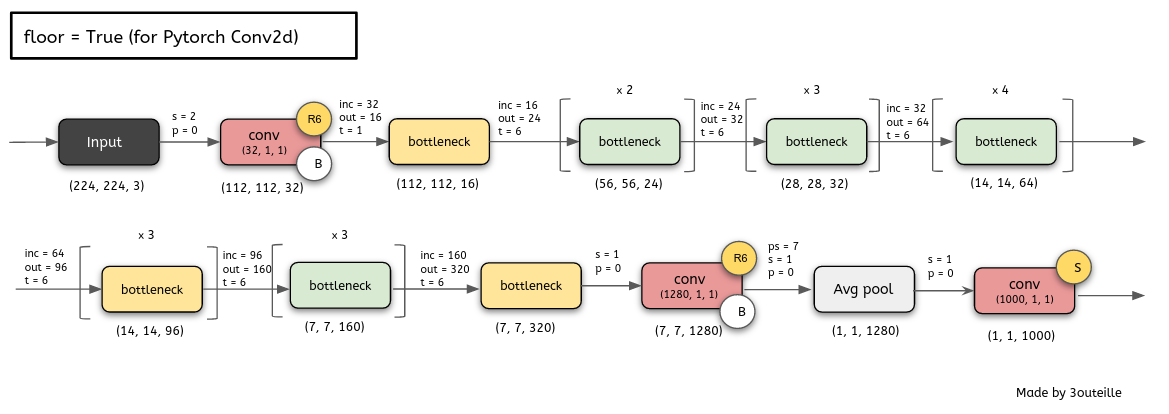

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling2D, Dense



# Load pre-trained MobileNetV2 model without the top (fully connected) layers
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3), pooling=None, classifier_activation="softmax")

# Freeze the layers of the pre-trained MobileNetV2 model
for layer in base_model.layers:
    layer.trainable = False

# Build your custom model on top of the pre-trained MobileNetV2
model = Sequential()
model.add(base_model)
model.add(GlobalMaxPooling2D())  # Use GlobalMaxPooling2D instead of MaxPooling2D
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Use 'binary' if it is two classes

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_max_pooling2d_3 (Gl  (None, 1280)              0         
 obalMaxPooling2D)                                               
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                                 
 dense_9 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 2915908 (11.12 MB)
Trainable params: 657924 (2.51 MB)
Non-trainable params: 2257984 (8.61 MB)
_______________

In [24]:
model_checkpoint_filpath6 = "model_checkpoint.h5"
callbacks_checkpoints6 = ModelCheckpoint(

    filepath = model_checkpoint_filpath6,
    save_weights_only = True,
    monitor = "val_accuracy",
    mode = "max",
    save_best_only = True
)

In [25]:
history = model.fit(train_data,
                    steps_per_epoch = len(train_data),
                    epochs = epochs,
                    validation_data = validation_data,
                    validation_steps = len(validation_data),
                    callbacks = [callbacks_checkpoints6]
                    )

Epoch 1/3
45/45 [==============================] - 40s 813ms/step - loss: 3.2090 - accuracy: 0.6070 - val_loss: 1.7934 - val_accuracy: 0.5178
Epoch 2/3
45/45 [==============================] - 37s 826ms/step - loss: 0.5017 - accuracy: 0.8084 - val_loss: 1.4359 - val_accuracy: 0.5609
Epoch 3/3
45/45 [==============================] - 37s 814ms/step - loss: 0.4368 - accuracy: 0.8328 - val_loss: 1.6701 - val_accuracy: 0.5787


In [26]:
loss, accuracy = model.evaluate(validation_data, batch_size=batch_size)

7/7 [==============================] - 2s 202ms/step - loss: 1.6701 - accuracy: 0.5787


# Conclusion
In conclusion, the provided code snippets showcase the implementation of transfer learning using popular pre-trained models (ResNet101, VGG19, Xception, and MobileNetV2) for image classification. These scripts efficiently leverage deep neural network architectures, freezing pre-trained layers, and appending custom classification layers. Additionally, ModelCheckpoint callbacks are employed to save the best models during training. This modular approach enables streamlined development of robust image classification models for various applications.

Please visit the others notebook:

* [Flowers classiffication VGG16](#https://www.kaggle.com/code/mostafizur1997/flowers-classfication-vgg16/edit/run/143791949)
* [Binary Image Classification Using CNN](#https://www.kaggle.com/code/mostafizur1997/binary-image-classification-using-cnn)
* [Spam Classification](#https://www.kaggle.com/code/mostafizur1997/spam-classification)
* [opencv Intermidate](#https://www.kaggle.com/code/mostafizur1997/opencv-intermidate)
